In [16]:
# Imports
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.cifar10 import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from matplotlib import pyplot

In [17]:
(trainX, trainy), (testX, testy) = load_data()

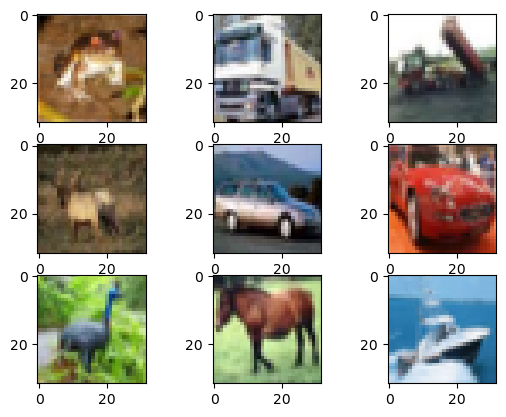

In [18]:
for i in range(9):
    # define subplot
    pyplot.subplot(330 + 1 + i)
    # plot raw pixel data
    pyplot.imshow(trainX[i])
# show the figure
pyplot.show()

In [19]:
def define_discriminator(in_shape=(32, 32, 3)):
    # It just a binary classification(Fake or Real?)
    model = Sequential()
    model.add(Conv2D(128, (3,3), strides=(2,2), padding="same", input_shape=in_shape))
    model.add(LeakyReLU(alpha=.2))
    
    model.add(Conv2D(128, (3,3), strides=(2,2), padding="same"))    
    model.add(LeakyReLU(alpha=.2))
    
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation="sigmoid")) # get prob
    
    # compile model
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [20]:
test_discr = define_discriminator()
test_discr.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 16, 16, 128)       3584      
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 8, 8, 128)         147584    
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dropout_2 (Dropout)         (None, 8192)              0         
                                                                 
 dense_4 (Dense)             (None, 1)                

In [21]:
# Start with 128*8*8 nodes in dense layer and gradually upscale to 32x32x3(generated image size)
def define_generator(latent_dim):
    model = Sequential()
    n_nodes = 128*8*8
    # We will reshape input latent vector into 8x8 image as a starting point. 
    # So n_nodes for the Dense layer can be 128x8x8 so when we reshape the output 
    # it would be 8x8x128 and that can be slowly upscaled to 32x32 image for output
    # First layer just a vector(Dense)
    model.add(Dense(n_nodes, input_dim=latent_dim)) # Dense layer so we can work with 1D latent vector
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((8, 8, 128))) # #8x8x128 dataset from the latent vector. 
    # upsample to 16x16
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding="same")) 
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 32x32
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) #32x32x128
    model.add(LeakyReLU(alpha=0.2))
    # Generate
    model.add(Conv2D(3, (8,8), activation='tanh', padding='same')) #32x32x3  
    # Actiavation -1 between 1. we need to convert pixel values to between -1 and 1!
    # We are not training generator directly. Generator is trained in combined gan model
    return model

In [22]:
test_gen = define_generator(100)
test_gen.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 8192)              827392    
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 8192)              0         
                                                                 
 reshape_2 (Reshape)         (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 16, 16, 128)      262272    
 ranspose)                                                       
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 32, 32, 128)      262272    
 ranspose)                                            

In [23]:
def define_gan(generator, discriminator):
    discriminator.trainable = False # Discriminator is trained separately. So set to not trainable.
    
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    
    # compile models
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss="binary_crossentropy", optimizer=opt)
    return model

In [24]:
def load_real_samples():
    (trainX, _), (_, _) = load_data()
    X = trainX.astype("float32")
    #original images to -1 to 1 to match the output of generator.
    X = (X-127.5)/127.5 # Generator uses tanh activation so rescale 
    return X

In [25]:
def generate_real_samples(dataset, n_samples):
    # choose random images
    ix = randint(0, dataset.shape[0], n_samples)
    # select the random images and assign it to X
    X = dataset[ix]
    # generate class labels and assign to y
    y = ones((n_samples, 1)) ##Label=1 indicating they are real
    return X, y

In [2]:
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

In [27]:
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict using generator to generate fake samples. 
    X = generator.predict(x_input)
    # Class labels will be 0 as these samples are fake. 
    y = zeros((n_samples, 1))  #Label=0 indicating they are fake
    return X, y

In [28]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
    bat_per_epo = int(dataset.shape[0]/n_batch) # total_number_of_img / batch_size
    
    # the discriminator model is updated for a half batch of real samples 
    # and a half batch of fake samples, combined a single batch. 
    half_batch = int(n_batch/2)
    
    for i in range(n_epochs):
        for j in range(bat_per_epo):
            # Train the discriminator on real and fake images, separately (half batch each)
            # Research showed that separate training is more effective. 
            # get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            
            
            # train_on_batch allows you to update weights based on a collection 
            # of samples you provide
            # Let us just capture loss and ignore accuracy value (2nd output below)
            d_loss_real, _ = d_model.train_on_batch(X_real, y_real)
            
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights
            d_loss_fake, _ = d_model.train_on_batch(X_fake, y_fake)
            print("DISCRIMINATOR TRAINING IS DONE!")
            print("-------------------------------")
            print("Starting train Generator!")
            
            
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            
            # The generator wants the discriminator to label the generated samples
            # as valid (ones)
            # This is where the generator is trying to trick discriminator into believing
            # the generated image is true (hence value of 1 for y)
            y_gan = ones((n_batch, 1))
            
            # Generator is part of combined model where it got directly linked with the discriminator
            # Train the generator with latent_dim as x and 1 as y. 
            # Again, 1 as the output as it is adversarial and if generator did a great
            #job of folling the discriminator then the output would be 1 (true)
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan ,y_gan)
            
            # Print losses on this batch
            print('Epoch>%d, Batch %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
                  (i+1, j+1, bat_per_epo, d_loss_real, d_loss_fake, g_loss))
            
            # save the generator model
            g_model.save('cifar_generator_2epochs.h5')

In [29]:
latent_dim = 100 # This is the size of the vector
discriminator = define_discriminator()
generator = define_generator(latent_dim)
gan_model = define_gan(generator, discriminator)
# Load image data
dataset = load_real_samples()

In [ ]:
import tensorflow as tf
tf.config.list_physical_devices("GPU")

In [ ]:
train(generator, discriminator, gan_model, dataset, latent_dim, n_epochs=250)

1/1 [==============================] - 0s 105ms/step


2022-11-08 16:12:54.200076: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-08 16:12:54.258021: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


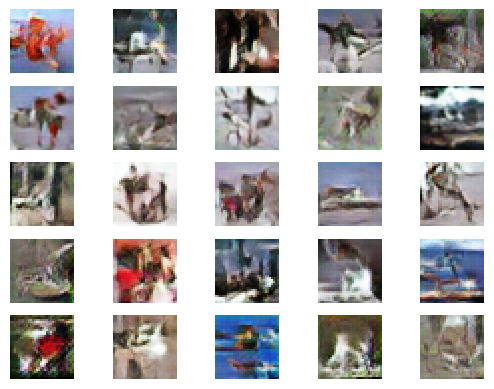

In [3]:
from keras.models import load_model
from numpy.random import randn
import matplotlib.pyplot as plt

# Plot generated images 
def show_plot(examples, n):
	for i in range(n * n):
		plt.subplot(n, n, 1 + i)
		plt.axis('off')
		plt.imshow(examples[i, :, :, :])
	plt.show()

# load model
model = load_model('cifar_generator_2epochs.h5') #Model trained for 100 epochs
# generate images
latent_points = generate_latent_points(100, 25)  #Latent dim and n_samples
# generate images
X = model.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0

import numpy as np
X = (X*255).astype(np.uint8)

# plot the result
show_plot(X, 5)